# Maze Experiment Introduction

In this notebook, we will be running the MDP_Model on the Maze problem. This 2D simulation builds on a `gym-maze` package that can be found here: https://github.com/MattChanTK/gym-maze. Before beginning this simulation, please be sure to install the relevant packages on the github **Installation** section (pygame and numpy are also required)!

## Running the Algorithm - Optimal Clustering 5x5

We can generate bigger mazes using the same method as above! Then, we will test to see if the optimal policy found by the maze is the same as the real optimal policy. 

#### Importing Modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import gym
import gym_maze
import pickle

import sys
sys.path.append('/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/')

from model import MDP_model
from maze_functions import createSamples, opt_maze_trajectory, opt_model_trajectory, policy_accuracy, \
    get_maze_transition_reward, plot_paths, value_diff, get_maze_MDP, value_est, opt_path_value_diff
from MDPtools import SolveMDP
from testing import cluster_size, next_clusters, training_value_error, purity, plot_features, testing_value_error, \
    generalization_accuracy

mazes = {1: 'maze-v0',
         2: 'maze-sample-3x3-v0',
         3: 'maze-random-3x3-v0',
         4: 'maze-sample-5x5-v0',
         5: 'maze-random-5x5-v0',
         6: 'maze-sample-10x10-v0',
         7: 'maze-random-10x10-v0',
         8: 'maze-sample-100x100-v0',
         9: 'maze-random-100x100-v0',
         10: 'maze-random-10x10-plus-v0', # has portals 
         11: 'maze-random-20x20-plus-v0', # has portals 
         12: 'maze-random-30x30-plus-v0'} # has portals 

#### Setting Parameters

In [2]:
# Setting Parameters
N = 200
T_max = 25
r = 0.4
maze = mazes[4]

In [4]:
# Setting parameters for model fitting
max_k = 25
classification = 'DecisionTreeClassifier'
split_classifier_params = {'random_state':0, 'max_depth':2}
clustering = 'Agglomerative'
n_clusters = None
distance_threshold = 0.5
precision_thresh = 1e-14
random_state = 0
pfeatures = 2
gamma = 1
actions = [0, 1, 2, 3]
h = -1
cv = 5
th = 0
eta = 25

Ns = [10, 20, 30, 40, 50, 70, 90, 110, 130, 150, 170, 200]
#Ns = [20]

P, R = get_maze_MDP(maze)
K = 100
f, rw = get_maze_transition_reward(maze)
true_v, true_pi = SolveMDP(P, R, prob='max', gamma=1, epsilon=1e-8)

pygame 2.0.0.dev10 (SDL 2.0.12, python 3.7.7)
Hello from the pygame community. https://www.pygame.org/contribute.html
Optimal Value: [0.44 0.48 0.52 0.8  0.84 0.32 0.44 0.56 0.84 0.88 0.36 0.4  0.6  0.8
 0.92 0.56 0.6  0.64 0.76 0.96 0.52 0.64 0.68 0.72 1.   0.  ]
Optimal Policy: [2 2 1 2 1 1 0 1 2 1 2 0 1 0 1 2 1 1 0 1 0 2 2 0 0 0]


### (Optional) Creating New Datasets:

You can choose to create and save new datasets to be trained here: simply link the folder you save the data in to the `path` section of the Training. Otherwise, you can also train the model using pre-made datasets provided.

In [ ]:
# choose number of sets to create
sets = 10

for n in range(sets):
    df = createSamples(N, T_max, maze, r, reseed=True)
    df.to_csv(f'set_{n}.csv')

## Train Models

In [1]:
# UPDATE with path and filename for dataset you want to use!
#path = '/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids_Dropbox/Maze/Model Data/Datasets/Set 1 (N=200, T_max = 25, randomness=0.4)'
path = '/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids_Dropbox/Maze/Model Data/Datasets/Set 2 (risk = -0.04)'
sys.path.append(path)

for set_num in range(150, 200):
    filename = f'set_{set_num}.csv'
    df = pd.read_csv(path+'/'+filename)

    # taking out extra ID col and changing actions back to integers
    df = df.iloc[:, 1:]
    df.loc[df['ACTION']=='None', 'ACTION'] = 4
    df['ACTION'] = pd.to_numeric(df['ACTION'], downcast='integer')
    df.loc[df['ACTION']==4, 'ACTION'] = 'None'
    
    df_full = df.copy()
    
    models=[]
    for n in Ns:
        df_small = df_full.loc[df_full['ID']<n]

        m = MDP_model()
        m.fit(df_small, # df: dataframe in the format ['ID', 'TIME', ...features..., 'RISK', 'ACTION']
            pfeatures, # int: number of features
            h, # int: time horizon (# of actions we want to optimize)
            gamma, # discount factor
            max_k, # int: number of iterations
            distance_threshold, # clustering diameter for Agglomerative clustering
            cv, # number for cross validation
            th, # splitting threshold
            eta, # incoherence threshold
            precision_thresh, # precision threshold
            classification, # classification method
            split_classifier_params, # classification params
            clustering,# clustering method from Agglomerative, KMeans, and Birch
            n_clusters, # number of clusters for KMeans
            random_state,
            plot=True,
            optimize=True)
        print('N=', n, ' completed')
        models.append(m)
    
    df_test = createSamples(N, T_max, maze, r, reseed=True)
    tr_acc, test_acc = generalization_accuracy(models, df_test, Ns)
    opt_gap = value_diff(models, Ns, K, T_max, P, R, f, rw, true_v, true_pi)
    val_est = value_est(models, Ns, K, P, R, f, rw, true_v, true_pi)
    opt_act_gap = opt_path_value_diff(models, Ns, K, T_max, P, R, f, r, true_v, true_pi)
    
    # save models
    for i in range(len(Ns)):
        x = Ns[i]
        pickle.dump(models[i], open(f'round_{set_num}_model_N={x}.sav', 'wb'))
        
    # save accuracies and optimality gap, value est
    pickle.dump(tr_acc, open(f'round_{set_num}_training_acc.sav', 'wb'))
    pickle.dump(test_acc, open(f'round_{set_num}_testing_acc.sav', 'wb'))
    pickle.dump(opt_gap, open(f'round_{set_num}_opt_gap.sav', 'wb'))
    pickle.dump(val_est, open(f'round_{set_num}_value_est.sav', 'wb'))
    pickle.dump(opt_act_gap, open(f'round_{set_num}_opt_act_gap.sav', 'wb'))

    
        


NameError: name 'sys' is not defined

## Optimality Gap

In [16]:
for i in range(len(Ns)):
        x = Ns[i]
        pickle.dump(models[i], open(f'round_{set_num}_model_N={x}.sav', 'wb'))

[144.7324 129.1236 106.838   74.3688  72.3992  37.078   20.6408  13.7408
   8.3088   6.7708   8.0732   2.0428]


(0, 1.5186688)

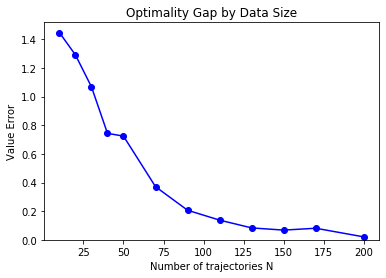

In [8]:
gap = np.zeros(len(Ns))
for set_num in range(100):
    gap += pickle.load(open(f'round_{set_num}_opt_gap.sav', 'rb'))
    #gap = pickle.load(open(f'round_{set_num}_opt_gap.sav', 'rb'))
    #print('set', set_num)
#     fig1, ax1 = plt.subplots()
#     ax1.plot(Ns, gap)
#     ax1.set_title(f'Optimality Gap by Data Size {set_num}')
#     ax1.set_xlabel('N training data size')
#     ax1.set_ylabel('|V_alg-V*|')
#     ax1.set_ylim(0)
    

print(gap)
opt_gap = gap/100
fig1, ax1 = plt.subplots()
ax1.plot(Ns, opt_gap, 'bo-')
ax1.set_title('Optimality Gap by Data Size')
ax1.set_xlabel('Number of trajectories N')
ax1.set_ylabel('Value Error')
ax1.set_ylim(0)

In [4]:
# Recalculating and plotting opt_gap and val_est from solved model
# Set Parameters
P, R = get_maze_MDP(maze)
K = 100
f, rw = get_maze_transition_reward(maze)
true_v, true_pi = SolveMDP(P, R, prob='max', gamma=0.999, epsilon=1e-8)

for i in range(50):
    models = []
    for n in Ns: 
        m = pickle.load(open(f'round_{i}_model_N={n}.sav', 'rb'))
        if m.v is None:
            m.solve_MDP(gamma=0.999, epsilon=1e-4)
        #pickle.dump(m, open(f'round_{i}_model_N={n}.sav', 'wb'))
        models.append(m)
    
    opt_gap = value_diff(models, Ns, K, T_max, P, R, f, rw, true_v, true_pi)
    val_est = value_est(models, Ns, K, P, R, f, rw, true_v, true_pi)
    
    pickle.dump(opt_gap, open(f'round_{i}_opt_gap.sav', 'wb'))
    pickle.dump(val_est, open(f'round_{i}_value_est.sav', 'wb'))
    
#     fig1, ax1 = plt.subplots()
#     ax1.plot(Ns, val_est)
#     ax1.set_title(f'Optimality Gap by Data Size {i}')
#     ax1.set_xlabel('N training data size')
#     ax1.set_ylabel('|V_alg-V*|')
#     ax1.set_ylim(0)
#     plt.show()
        


Optimal Value: [4.29718075e-01 4.70188261e-01 5.10698958e-01 7.95411548e-01
 8.36247794e-01 3.08550175e-01 4.29718075e-01 5.51250207e-01
 8.36247794e-01 8.77124917e-01 3.48899072e-01 3.89288359e-01
 5.91842047e-01 7.95411548e-01 9.18042958e-01 5.51250207e-01
 5.91842047e-01 6.32474519e-01 7.54616139e-01 9.59001958e-01
 5.10698958e-01 6.32474519e-01 6.73147665e-01 7.13861524e-01
 1.00000196e+00 1.95802767e-06]
Optimal Policy: [2 2 1 2 1 1 0 1 2 1 2 0 1 0 1 2 1 1 0 1 0 2 2 0 0 0]
Round N= 10
Round N= 20
Round N= 30
Round N= 40
Round N= 50
Round N= 70
Round N= 90
Round N= 110
Round N= 130
Round N= 150
Round N= 170
Round N= 200
[4.29718075e-01 4.70188261e-01 5.10698958e-01 7.95411548e-01
 8.36247794e-01 3.08550175e-01 4.29718075e-01 5.51250207e-01
 8.36247794e-01 8.77124917e-01 3.48899072e-01 3.89288359e-01
 5.91842047e-01 7.95411548e-01 9.18042958e-01 5.51250207e-01
 5.91842047e-01 6.32474519e-01 7.54616139e-01 9.59001958e-01
 5.10698958e-01 6.32474519e-01 6.73147665e-01 7.13861524e-01
 1

Round N= 10
Round N= 20
Round N= 30
Round N= 40
Round N= 50
Round N= 70
Round N= 90
Round N= 110
Round N= 130
Round N= 150
Round N= 170
Round N= 200
[4.29718075e-01 4.70188261e-01 5.10698958e-01 7.95411548e-01
 8.36247794e-01 3.08550175e-01 4.29718075e-01 5.51250207e-01
 8.36247794e-01 8.77124917e-01 3.48899072e-01 3.89288359e-01
 5.91842047e-01 7.95411548e-01 9.18042958e-01 5.51250207e-01
 5.91842047e-01 6.32474519e-01 7.54616139e-01 9.59001958e-01
 5.10698958e-01 6.32474519e-01 6.73147665e-01 7.13861524e-01
 1.00000196e+00 1.95802767e-06]
Round N= 10
model avg val 1.0
Round N= 20
model avg val 1.0
Round N= 30
model avg val 0.08626788064453866
Round N= 40
model avg val 0.08139441944638447
Round N= 50
model avg val 0.04047820996363672
Round N= 70
model avg val 0.04047820996363683
Round N= 90
model avg val 0.08261339402995128
Round N= 110
model avg val 2.5073328319691335e-06
Round N= 130
model avg val 3.80508392155976e-06
Round N= 150
model avg val 3.0318205272439336e-06
Round N= 170
mo

Round N= 10
Round N= 20
Round N= 30
Round N= 40
Round N= 50
Round N= 70
Round N= 90
Round N= 110
Round N= 130
Round N= 150
Round N= 170
Round N= 200
[4.29718075e-01 4.70188261e-01 5.10698958e-01 7.95411548e-01
 8.36247794e-01 3.08550175e-01 4.29718075e-01 5.51250207e-01
 8.36247794e-01 8.77124917e-01 3.48899072e-01 3.89288359e-01
 5.91842047e-01 7.95411548e-01 9.18042958e-01 5.51250207e-01
 5.91842047e-01 6.32474519e-01 7.54616139e-01 9.59001958e-01
 5.10698958e-01 6.32474519e-01 6.73147665e-01 7.13861524e-01
 1.00000196e+00 1.95802767e-06]
Round N= 10
model avg val 1.0
Round N= 20
model avg val 0.007292657194961563
Round N= 30
model avg val 0.015791396318646664
Round N= 40
model avg val 0.015791396318646664
Round N= 50
model avg val 0.01283539530073183
Round N= 70
model avg val 0.008506762784059435
Round N= 90
model avg val 0.001222129249472317
Round N= 110
model avg val 0.0012162243290305963
Round N= 130
model avg val 1.816464671677842e-06
Round N= 150
model avg val 1.0
Round N= 170


Round N= 10
Round N= 20
Round N= 30
Round N= 40
Round N= 50
Round N= 70
Round N= 90
Round N= 110
Round N= 130
Round N= 150
Round N= 170
Round N= 200
[4.29718075e-01 4.70188261e-01 5.10698958e-01 7.95411548e-01
 8.36247794e-01 3.08550175e-01 4.29718075e-01 5.51250207e-01
 8.36247794e-01 8.77124917e-01 3.48899072e-01 3.89288359e-01
 5.91842047e-01 7.95411548e-01 9.18042958e-01 5.51250207e-01
 5.91842047e-01 6.32474519e-01 7.54616139e-01 9.59001958e-01
 5.10698958e-01 6.32474519e-01 6.73147665e-01 7.13861524e-01
 1.00000196e+00 1.95802767e-06]
Round N= 10
model avg val 1.0
Round N= 20
model avg val 1.0
Round N= 30
model avg val 1.0
Round N= 40
model avg val 1.816464670911233e-06
Round N= 50
model avg val 5.102918799126943e-06
Round N= 70
model avg val 0.010003767033081677
Round N= 90
model avg val 0.01000376703308168
Round N= 110
model avg val 0.0012192085078969966
Round N= 130
model avg val 0.001215475000140097
Round N= 150
model avg val 1.3694110432282969e-06
Round N= 170
model avg val 

model avg val 1.0
Round N= 20
model avg val 0.12154015521241035
Round N= 30
model avg val 0.08098890696389936
Round N= 40
model avg val 0.031217796520501127
Round N= 50
model avg val 0.08098890696389958
Round N= 70
model avg val 5.102918799126943e-06
Round N= 90
model avg val 3.0318205254120656e-06
Round N= 110
model avg val 0.04000115269481747
Round N= 130
model avg val 3.031820525856155e-06
Round N= 150
model avg val 3.031820527410467e-06
Round N= 170
model avg val 2.507332834800202e-06
Round N= 200
model avg val 0.030002055177738813
Round N= 10
Round N= 20
Round N= 30
Round N= 40
Round N= 50
Round N= 70
Round N= 90
Round N= 110
Round N= 130
Round N= 150
Round N= 170
Round N= 200
[4.29718075e-01 4.70188261e-01 5.10698958e-01 7.95411548e-01
 8.36247794e-01 3.08550175e-01 4.29718075e-01 5.51250207e-01
 8.36247794e-01 8.77124917e-01 3.48899072e-01 3.89288359e-01
 5.91842047e-01 7.95411548e-01 9.18042958e-01 5.51250207e-01
 5.91842047e-01 6.32474519e-01 7.54616139e-01 9.59001958e-01
 5.1

Round N= 200
[4.29718075e-01 4.70188261e-01 5.10698958e-01 7.95411548e-01
 8.36247794e-01 3.08550175e-01 4.29718075e-01 5.51250207e-01
 8.36247794e-01 8.77124917e-01 3.48899072e-01 3.89288359e-01
 5.91842047e-01 7.95411548e-01 9.18042958e-01 5.51250207e-01
 5.91842047e-01 6.32474519e-01 7.54616139e-01 9.59001958e-01
 5.10698958e-01 6.32474519e-01 6.73147665e-01 7.13861524e-01
 1.00000196e+00 1.95802767e-06]
Round N= 10
model avg val 1.0
Round N= 20
model avg val 1.0
Round N= 30
model avg val 0.0024362348385700773
Round N= 40
model avg val 3.805083920893626e-06
Round N= 50
model avg val 0.00040720919586442305
Round N= 70
model avg val 0.0016239103709296198
Round N= 90
model avg val 0.032835853907137995
Round N= 110
model avg val 3.0318205254120656e-06
Round N= 130
model avg val 1.3694110419515404e-06
Round N= 150
model avg val 3.805083922336916e-06
Round N= 170
model avg val 0.000811911058899647
Round N= 200
model avg val 3.805083925001451e-06
Round N= 10
Round N= 20
Round N= 30
Round N

model avg val 0.0020326673608215664
Round N= 10
Round N= 20
Round N= 30
Round N= 40
Round N= 50
Round N= 70
Round N= 90
Round N= 110
Round N= 130
Round N= 150
Round N= 170
Round N= 200
[4.29718075e-01 4.70188261e-01 5.10698958e-01 7.95411548e-01
 8.36247794e-01 3.08550175e-01 4.29718075e-01 5.51250207e-01
 8.36247794e-01 8.77124917e-01 3.48899072e-01 3.89288359e-01
 5.91842047e-01 7.95411548e-01 9.18042958e-01 5.51250207e-01
 5.91842047e-01 6.32474519e-01 7.54616139e-01 9.59001958e-01
 5.10698958e-01 6.32474519e-01 6.73147665e-01 7.13861524e-01
 1.00000196e+00 1.95802767e-06]
Round N= 10
model avg val 1.0
Round N= 20
model avg val 0.08098890696389936
Round N= 30
model avg val 1.0
Round N= 40
model avg val 0.0008145066448643734
Round N= 50
model avg val 1.0
Round N= 70
model avg val 0.010145845870464161
Round N= 90
model avg val 0.00040850694695351576
Round N= 110
model avg val 0.02000372898224252
Round N= 130
model avg val 0.00040850694695423627
Round N= 150
model avg val 1.36941104339

In [12]:
v_opt = 0
s = 0
if true_v is None or true_pi is None:
    true_v, true_pi = SolveMDP(P, R, prob='max', gamma=0.999, epsilon=1e-8)
for t in range(25):
    v_opt += R[0, s]
    #print(R[0, s], v_opt)
    a = true_pi[s]
    s_new = P[a, s].argmax()
    s = s_new
print(v_opt)
print(R)

0.44000000000000006
[[-0.04 -0.04 -0.04 -0.04 -0.04 -0.04 -0.04 -0.04 -0.04 -0.04 -0.04 -0.04
  -0.04 -0.04 -0.04 -0.04 -0.04 -0.04 -0.04 -0.04 -0.04 -0.04 -0.04 -0.04
   1.    0.  ]
 [-0.04 -0.04 -0.04 -0.04 -0.04 -0.04 -0.04 -0.04 -0.04 -0.04 -0.04 -0.04
  -0.04 -0.04 -0.04 -0.04 -0.04 -0.04 -0.04 -0.04 -0.04 -0.04 -0.04 -0.04
   1.    0.  ]
 [-0.04 -0.04 -0.04 -0.04 -0.04 -0.04 -0.04 -0.04 -0.04 -0.04 -0.04 -0.04
  -0.04 -0.04 -0.04 -0.04 -0.04 -0.04 -0.04 -0.04 -0.04 -0.04 -0.04 -0.04
   1.    0.  ]
 [-0.04 -0.04 -0.04 -0.04 -0.04 -0.04 -0.04 -0.04 -0.04 -0.04 -0.04 -0.04
  -0.04 -0.04 -0.04 -0.04 -0.04 -0.04 -0.04 -0.04 -0.04 -0.04 -0.04 -0.04
   1.    0.  ]]
[[ -0.04   1.    -0.04  -0.04  -0.04  -0.04  -0.04  -0.04  -0.04  -0.04
   -0.04  -0.04  -0.04  -0.04  -0.04  -0.04  -0.04  -0.04  -0.04  -0.04
   -0.04  -0.04  -0.04   0.   -10.  ]
 [ -0.04   1.    -0.04  -0.04  -0.04  -0.04  -0.04  -0.04  -0.04  -0.04
   -0.04  -0.04  -0.04  -0.04  -0.04  -0.04  -0.04  -0.04  -0.04  -0.04
 

## Value Estimate

round 0 4.218847493575595e-15
round 1 4.6629367034256575e-15
round 2 4.884981308350689e-15
round 3 0.07120000000000394
round 4 0.0020000000000044206
round 5 0.0012000000000048727
round 6 0.002000000000004416
round 7 0.02000000000000435
round 8 4.440892098500626e-15
round 9 5.10702591327572e-15
round 10 4.440892098500626e-15
round 11 0.0028000000000046343
round 12 0.0008000000000046547
round 13 0.0008000000000044327
round 14 0.07000000000000432
round 15 0.040000000000004705
round 16 3.983480212355062e-15
round 17 0.09000000000000384
round 18 0.002400000000004634
round 19 4.884981308350689e-15
round 20 4.440892098500626e-15
round 21 0.0020000000000046426
round 22 0.0008000000000048768
round 23 0.0012000000000044286
round 24 0.05000000000000465
round 25 0.030000000000004093
round 26 0.00040000000000377066
round 27 0.010000000000004396
round 28 0.07000000000000395
round 29 5.10702591327572e-15
round 30 0.05000000000000401
round 31 4.884981308350689e-15
round 32 4.6629367034256575e-15
round

(0, 0.878404)

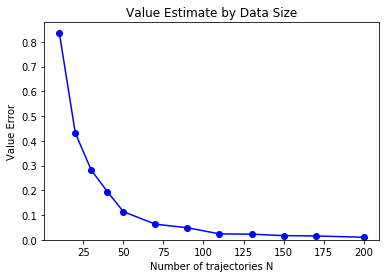

In [11]:
est = np.zeros(len(Ns))
for set_num in range(200):
    val_est = pickle.load(open(f'round_{set_num}_value_est.sav', 'rb'))
    print('round', set_num, val_est[-1])
    val_est = [float(x) for x in val_est]
    est += val_est
    

print(est)
avg_est = est/200
print('average estimate', avg_est)
fig1, ax1 = plt.subplots()
ax1.plot(Ns, avg_est, 'bo-')
ax1.set_title('Value Estimate by Data Size')
ax1.set_xlabel('Number of trajectories N')
ax1.set_ylabel('Value Error')
ax1.set_ylim(0)


In [19]:
est = value_est([m], [200], 100, P, R, f, r, true_v, true_pi)

[4.29718075e-01 4.70188261e-01 5.10698958e-01 7.95411548e-01
 8.36247794e-01 3.08550175e-01 4.29718075e-01 5.51250207e-01
 8.36247794e-01 8.77124917e-01 3.48899072e-01 3.89288359e-01
 5.91842047e-01 7.95411548e-01 9.18042958e-01 5.51250207e-01
 5.91842047e-01 6.32474519e-01 7.54616139e-01 9.59001958e-01
 5.10698958e-01 6.32474519e-01 6.73147665e-01 7.13861524e-01
 1.00000196e+00 1.95802767e-06]
Round N= 200
model avg val 1.5717411305238294e-06


In [23]:
#plot_features(m.df_trained, 'FEATURE_0', 'FEATURE_1')
def purity(df):
    su = pd.DataFrame(df.groupby(['OG_CLUSTER'])['CLUSTER']
    .value_counts(normalize=True)).reset_index(level=0)
    su.columns= ['OG_CLUSTER','Purity']
    return su.groupby('OG_CLUSTER')['Purity'].max()
purity(m.df_trained)

OG_CLUSTER
0     0.972727
1     0.959064
2     0.994302
3     0.500000
4     0.950000
6     0.953125
7     0.994318
8     0.935811
9     0.992780
10    1.000000
11    0.928571
12    0.990798
13    0.950331
14    0.987654
17    0.987539
18    0.945860
19    1.000000
21    1.000000
22    0.964401
23    0.954397
24    1.000000
Name: Purity, dtype: float64

In [33]:
models = [] 
for i in range(50):
    m = pickle.load(open(f'round_{i}_model_N=200.sav', 'rb'))
    models.append(m)

for i in range(50):
    m = models[i]
    print('round', i, purity(m.df_trained).loc[0])

round 0 0.9579288025889967
round 1 0.640117994100295
round 2 0.8753894080996885
round 3 0.8637770897832817
round 4 0.9659090909090909
round 5 0.9141104294478528
round 6 0.9969512195121951
round 7 0.8895027624309392
round 8 0.9635258358662614
round 9 1.0
round 10 0.9968454258675079
round 11 0.9706744868035191
round 12 0.9842767295597484
round 13 0.9686520376175548
round 14 0.9095890410958904
round 15 0.9662921348314607
round 16 0.9797101449275363
round 17 0.6755162241887905
round 18 0.9818181818181818
round 19 0.9876923076923076
round 20 0.9908256880733946
round 21 0.9850299401197605
round 22 0.9754601226993865
round 23 0.9607250755287009
round 24 0.8690476190476191
round 25 0.9538461538461539
round 26 0.9875
round 27 0.9852507374631269
round 28 0.9703264094955489
round 29 0.9882005899705014
round 30 0.9705014749262537
round 31 1.0
round 32 0.7022653721682848
round 33 1.0
round 34 0.912568306010929
round 35 1.0
round 36 0.9619047619047619
round 37 0.9939393939393939
round 38 1.0
round 3

,Clusters,Error
0,3,8.544472e-01
1,4,8.544472e-01
2,5,8.544472e-01
3,6,8.544472e-01
4,7,8.544472e-01
5,8,8.544472e-01
6,9,8.544472e-01
7,10,8.544472e-01
8,11,8.544472e-01
9,12,8.544472e-01


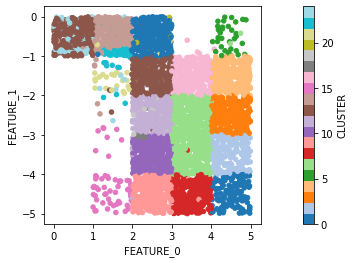

In [39]:
plot_features(models[41].df_trained, 'FEATURE_0', 'FEATURE_1')
models[41].training_error

## Optimal Action Value Difference

[88.94   46.9352 20.37   14.03   12.15    6.54    5.02    2.21    2.55
  2.08    2.14    1.21  ]


(0, 0.9332649999999998)

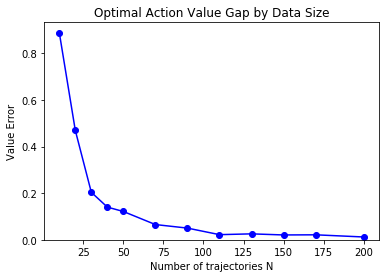

In [13]:
gap = np.zeros(len(Ns))
for set_num in range(100):
    gap += pickle.load(open(f'round_{set_num}_opt_act_gap.sav', 'rb'))
    #gap = pickle.load(open(f'round_{set_num}_opt_gap.sav', 'rb'))
    #print('set', set_num)
#     fig1, ax1 = plt.subplots()
#     ax1.plot(Ns, gap)
#     ax1.set_title(f'Optimality Gap by Data Size {set_num}')
#     ax1.set_xlabel('N training data size')
#     ax1.set_ylabel('|V_alg-V*|')
#     ax1.set_ylim(0)
    

print(gap)
opt_gap = gap/100
fig1, ax1 = plt.subplots()
ax1.plot(Ns, opt_gap, 'bo-')
ax1.set_title('Optimal Action Value Gap by Data Size')
ax1.set_xlabel('Number of trajectories N')
ax1.set_ylabel('Value Error')
ax1.set_ylim(0)

In [ ]:
# calculating and saving optimal action value difference
for i in range(50):
    models = []
    for n in Ns: 
        m = pickle.load(open(f'round_{i}_model_N={n}.sav', 'rb'))
        if m.v is None:
            m.solve_MDP(gamma=1, epsilon=1e-4)
        #pickle.dump(m, open(f'round_{i}_model_N={n}.sav', 'wb'))
        models.append(m)
    
    opt_act_gap = opt_path_value_diff(models, Ns, K, T_max, P, R, f, rw, true_v, true_pi)
    
    pickle.dump(opt_act_gap, open(f'round_{i}_opt_act_gap.sav', 'wb'))

## Averages

(0, 1)

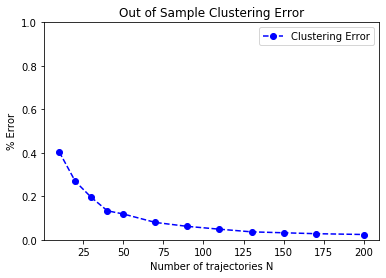

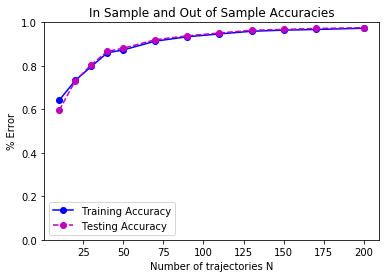

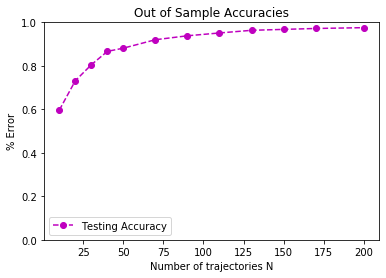

In [15]:
tr_acc = np.zeros(len(Ns))
test_acc = np.zeros(len(Ns))
for set_num in range(100):
    tr_acc += pickle.load(open(f'round_{set_num}_training_acc.sav', 'rb'))
    test_acc += pickle.load(open(f'round_{set_num}_testing_acc.sav', 'rb'))

train_acc = tr_acc/100
testing_acc = test_acc/100
fig1, ax1 = plt.subplots()
ax1.plot(Ns, 1-np.array(testing_acc), 'bo--', label='Clustering Error')
ax1.set_title('Out of Sample Clustering Error')
ax1.set_xlabel('Number of trajectories N')
ax1.set_ylabel('% Error')
ax1.legend()
ax1.set_ylim(0, 1)

fig2, ax2 = plt.subplots()
ax2.plot(Ns, train_acc, 'bo-', label='Training Accuracy')
ax2.plot(Ns, np.array(testing_acc), 'mo--', label='Testing Accuracy')
ax2.set_title('In Sample and Out of Sample Accuracies')
ax2.set_xlabel('Number of trajectories N')
ax2.set_ylabel('% Error')
ax2.legend()
ax2.set_ylim(0, 1)

fig2, ax3 = plt.subplots()
#ax3.plot(Ns, train_acc, 'bo-', label='Training Accuracy')
ax3.plot(Ns, np.array(testing_acc), 'mo--', label='Testing Accuracy')
ax3.set_title('Out of Sample Accuracies')
ax3.set_xlabel('Number of trajectories N')
ax3.set_ylabel('% Error')
ax3.legend()
ax3.set_ylim(0, 1)

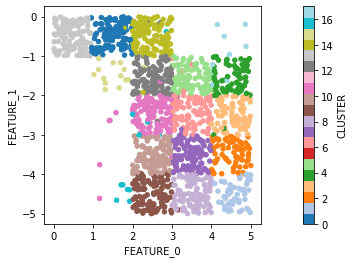

In [25]:
m = pickle.load(open(f'round_11_model_N=70.sav', 'rb'))
plot_features(m.df_trained, 'FEATURE_0', 'FEATURE_1', 'CLUSTER')

And compare it with a clustering with the actual cells of the Maze.

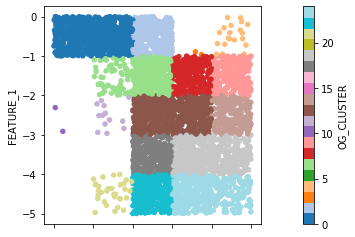

In [37]:
plot_features(m.df_trained, 'FEATURE_0', 'FEATURE_1', 'OG_CLUSTER')

Now, let's see what the optimal policy our model learns is:

/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_discrete_distns.py:46: RuntimeWarning: invalid value encountered in greater_equal
  return (n >= 0) & (p >= 0) & (p <= 1)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:3072: RuntimeWarning: invalid value encountered in greater_equal
  cond1 = (k >= _a) & (k < _b)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/model.py:357: RuntimeWarning: invalid value encountered in less_equal
  beta))<=alpha]
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/model.py:387: RuntimeWarning: invalid value encountered in greater
  beta))>alpha]


Optimal Value: [ 2.86363020e-01  1.00000000e+00  8.96000000e-01  8.02400000e-01
  7.18160000e-01  6.42344000e-01  5.74109600e-01  5.12698640e-01
  4.57428776e-01  4.07685898e-01  3.62917309e-01  3.22625578e-01
  2.86363020e-01  3.22625578e-01  2.86363020e-01  3.62917309e-01
  6.42344000e-01  2.86363020e-01  5.74109600e-01  8.31806849e-13
 -1.00000000e+03]
Optimal Policy: [3 0 1 1 1 2 0 0 0 2 1 1 1 1 2 2 1 2 2 0 0]


/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Maze/maze_functions.py:160: RuntimeWarning: invalid value encountered in true_divide
  ax.quiver(pos_x, pos_y, u/norm, v/norm, angles="xy", zorder=5, pivot="mid")


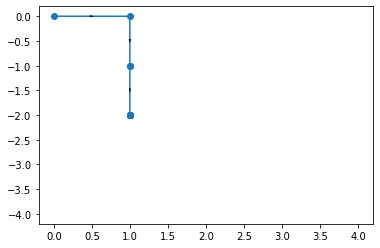

(array([0., 1., 1., ..., 1., 1., 1.]),
 array([-0.,  0., -1., ..., -2., -2., -2.]))

In [49]:
opt_model_trajectory(m, maze, alpha=0.2)

And here is an actual simulation of a point through the maze by taking the found optimal policy. Note that we have set a sink node as the bottom left corner, which is where the path will go once it has reached the goal state.

In [59]:
m.nc.loc[13]

,NEXT_CLUSTER,count,purity
ACTION,,,
0,13,33,0.787879
1,15,33,0.939394
2,0,232,1.000000
3,14,35,0.885714


In [62]:
m.df_trained.shape
4554*0.009

40.986

In [40]:
m.solve_MDP(beta=0.6)

Optimal Value: [ 2.24354046e-01  1.00000000e+00  8.96000000e-01  8.02400000e-01
  7.18160000e-01  6.42344000e-01  5.74109600e-01  5.12698640e-01
  4.57428776e-01  4.07685898e-01  3.62917309e-01  3.22625578e-01
  1.97918642e-01  1.97918642e-01  2.53726718e-01  2.86363020e-01
  3.62917309e-01 -9.00004000e+02  6.06387193e-13 -1.00000000e+03]
Optimal Policy: [2 0 1 1 1 2 0 0 0 2 1 1 0 2 1 1 2 0 0 0]


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_discrete_distns.py:46: RuntimeWarning: invalid value encountered in greater_equal
  return (n >= 0) & (p >= 0) & (p <= 1)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:3072: RuntimeWarning: invalid value encountered in greater_equal
  cond1 = (k >= _a) & (k < _b)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/model.py:357: RuntimeWarning: invalid value encountered in less_equal
  beta))<=alpha]
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/model.py:387: RuntimeWarning: invalid value encountered in greater
  beta))>alpha]


(array([ 2.24354046e-01,  1.00000000e+00,  8.96000000e-01,  8.02400000e-01,
         7.18160000e-01,  6.42344000e-01,  5.74109600e-01,  5.12698640e-01,
         4.57428776e-01,  4.07685898e-01,  3.62917309e-01,  3.22625578e-01,
         1.97918642e-01,  1.97918642e-01,  2.53726718e-01,  2.86363020e-01,
         3.62917309e-01, -9.00004000e+02,  6.06387193e-13, -1.00000000e+03]),
 array([2, 0, 1, 1, 1, 2, 0, 0, 0, 2, 1, 1, 0, 2, 1, 1, 2, 0, 0, 0]))

states [[array([13]), 2], [array([0]), 2], [array([14]), 1], [array([15]), 1], [array([11]), 1], [array([10]), 1], [array([9]), 2], [array([8]), 0], [array([7]), 0], [array([6]), 0], [array([17]), 0], [array([5]), 2], [array([4]), 1], [array([3]), 1], [array([2]), 1], [array([1]), 0]]


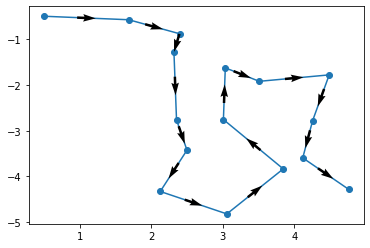

(array([0.5       , 1.68338646, 2.39400653, 2.31607022, 2.35244357,
        2.49869742, 2.12453461, 3.05662903, 3.84610566, 3.00843247,
        3.03493875, 3.50964945, 4.48895061, 4.25715787, 4.11875857,
        4.75950239]),
 array([-0.5       , -0.5764082 , -0.88187433, -1.28189791, -2.76542501,
        -3.42488951, -4.3274173 , -4.81797811, -3.83453529, -2.75624022,
        -1.6273533 , -1.92143664, -1.78085714, -2.7800845 , -3.59406439,
        -4.27902911]))

In [27]:
f, rw = get_maze_transition_reward(maze)
x0= (0.5, -0.5)
m.opt_model_trajectory(x0, f)

And finally, here is the optimal policy for reference:

## Saving Relevant Models

In [42]:
# m = pickle.load(open('round_6_model_N=90.sav', 'rb'))
# m.incoherences['Error'] = m.training_error['Error']
# m.incoherences